In [6]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from nim_env import NimEnv, OptimalPlayer
import helpers 

import torch
import torch.nn as nn
import torch.optim as optim
import WarningFunctions as wf


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#parameters
GAMMA = 0.99
buffer_size = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 500


#-------------------------------- helpers DQN ----------------------------
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
#next state here consists of the next state the DQN player can play; i.e. not the next state that the game has, but the one after. 


class Memory_Q12(object):
    #without the replay buffer and with a batch size of 1. At every step,  we will update the network by using only the latest transition.
    def __init__(self):
        self.state = None
        self.action = None
        self.next_state = None
        self.reward = None

    def push(self, state, action, next_state, reward):
        """Save a transition"""
        self.state = state
        self.action = action
        self.next_state = next_state
        self.reward = reward



class DQN_Player_no_RB(helpers.DQN_Player):
    def __init__(self, player: int, policy_net : helpers.DQN, target_net : helpers.DQN, memory : Memory_Q12, EPS_GREEDY: float = 0.2, GAMMA : float = 0.99, buffer_size: int = 10000, BATCH_SIZE: int = 1, TARGET_UPDATE: int = 500):
        #here memory is not a replay buffer, but can just contain the latest transition.
        super(helpers.DQN_Player, self).__init__(player = player)
        self.policy_net = policy_net
        self.target_net = target_net
        self.memory = memory
        self.player = player
        self.EPS_GREEDY = EPS_GREEDY
        self.GAMMA = GAMMA
        self.buffer_size = buffer_size
        self.BATCH_SIZE = BATCH_SIZE
        self.TARGET_UPDATE = TARGET_UPDATE
        self.count = 0 #to count when to update target_net.

        self.optimizer = optim.Adam(policy_net.parameters(), lr = 1e-4)

    def optimize(self):   
        #the batch consist of the memory (of size 1)     
        batch = self.memory 
        # Compute a mask of non-final states and concatenate the batch elements
        non_final_mask = torch.tensor(batch.next_state != None)
        #non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        if batch.next_state != None : #is false if the list is empty
            non_final_next_states = batch.next_state
        else : #if there is no non-final next states
            non_final_next_states = torch.empty(0) 

        state_batch = batch.state
        action_batch = batch.action
        reward_batch = batch.reward

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch) #64 x 21
        state_action_values = state_action_values.gather(1, ((action_batch[::2]-1)*7+(action_batch[1::2]-1)).view(self.BATCH_SIZE, 1)) #Batch_size x 1

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        if len(non_final_next_states) > 0 :
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach() 
            # max(1) : take the maximum per batch on the 21 possibilities. [0]: take the max and not the argmax
                
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch  #64

        # Compute Huber loss
        criterion = nn.HuberLoss()
        loss = criterion(state_action_values.squeeze(), expected_state_action_values.detach())

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()


    def memory_push(self, state, action, next_state, reward): 
        #push the transition in the memory buffer
        self.memory.push(state, action, next_state, reward)




def Q12(policy_net : helpers.DQN(), target_net : helpers.DQN(), memory : Memory_Q12, nb_games : int = 20000, eps : float = 0.1, eps_opt : float = 0.5, step : int = 250, seed = None, question : str = 'q3-12'):
    Rewards = np.zeros(int(nb_games / step))
    Steps = np.zeros(int(nb_games / step))
    Losses = np.zeros(int(nb_games / step))
    total_reward = 0.0
    total_loss = 0.0
    env = NimEnv(seed = seed)
    playerOpt = OptimalPlayer(epsilon = eps_opt, player = 0)
    playerDQN = DQN_Player_no_RB(player = 1, policy_net = policy_net, target_net= target_net, memory=memory, EPS_GREEDY = eps) 
    for i in range(nb_games):
        if i%step ==0:
            print('New game : ', i)
        # switch turns at every game
        if i % 2 == 0:
            playerOpt.player = 0
            playerDQN.player = 1
        else:
            playerOpt.player = 1
            playerDQN.player = 0
        
        new_reward, new_loss = helpers.DQN_one_game(playerDQN, playerOpt, env)
        total_reward += new_reward
        if new_loss != None: #the loss might be None if the opt. player directly wins.
            total_loss += new_loss
        if i % step == step - 1:
            Rewards[i // step] += total_reward / step
            Losses[i // step] += total_loss / step
            Steps[i // step] = i
            total_reward = 0.0
            total_loss = 0.0

        env.reset(seed = seed)

    plt.figure(figsize = (9, 8))
    plt.plot(Steps, Rewards)
    plt.title('Evolution of average reward every 250 games')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for QL-player')
    plt.savefig('./Data/' + question + '_rewards.png')
    plt.show()

    plt.figure(figsize = (9, 8))
    plt.plot(Steps, Losses)
    plt.title('Evolution of average loss every 250 games')
    plt.xlabel('Number of games played')
    plt.ylabel('Average loss for QL-player')
    plt.savefig('./Data/' + question + '_losses.png')
    plt.show()

# 3.2


Question 11

In [2]:
policy_net = helpers.DQN().to(device)
target_net = helpers.DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = helpers.ReplayMemory(buffer_size)

New game :  0
tensor([False, False, False, False,  True, False, False, False, False, False,
        False, False, False,  True, False,  True,  True, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True,  True, False, False, False,
         True, False, False, False, False, False, False, False,  True,  True,
        False

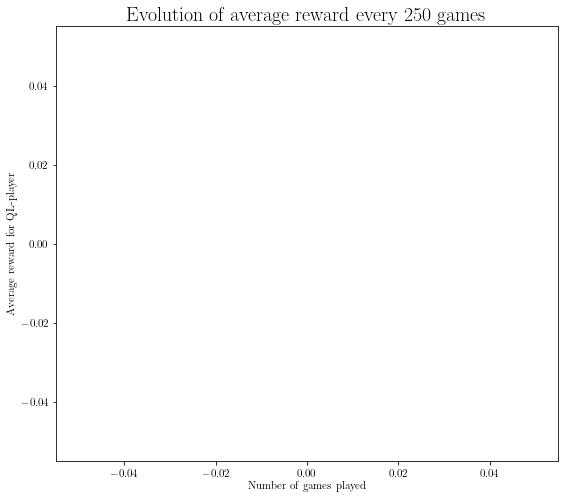

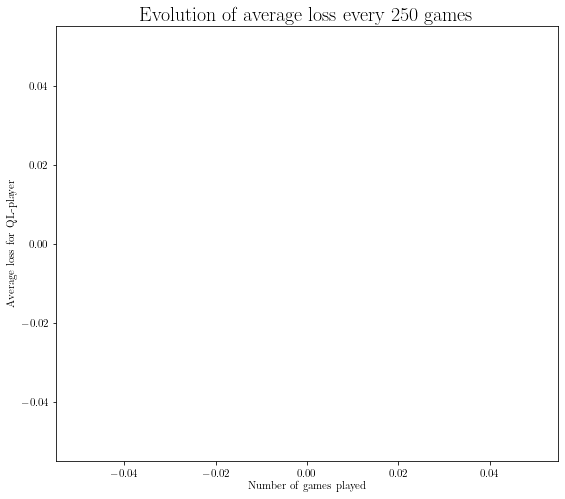

In [3]:
helpers.Q11(policy_net, target_net, memory, eps = 0.1, eps_opt = 0.5, nb_games=200, question = 'q3-11')

Question 12


New game :  0


/Users/Anya48/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:972: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


New game :  250
New game :  500
New game :  750
New game :  1000
New game :  1250
New game :  1500
New game :  1750
New game :  2000
New game :  2250
New game :  2500
New game :  2750
New game :  3000
New game :  3250
New game :  3500
New game :  3750
New game :  4000
New game :  4250
New game :  4500
New game :  4750
New game :  5000
New game :  5250
New game :  5500
New game :  5750
New game :  6000
New game :  6250
New game :  6500
New game :  6750
New game :  7000
New game :  7250
New game :  7500
New game :  7750
New game :  8000
New game :  8250
New game :  8500
New game :  8750
New game :  9000
New game :  9250
New game :  9500
New game :  9750
New game :  10000
New game :  10250
New game :  10500
New game :  10750
New game :  11000
New game :  11250
New game :  11500
New game :  11750
New game :  12000
New game :  12250
New game :  12500
New game :  12750
New game :  13000
New game :  13250
New game :  13500
New game :  13750
New game :  14000
New game :  14250
New game :  1450

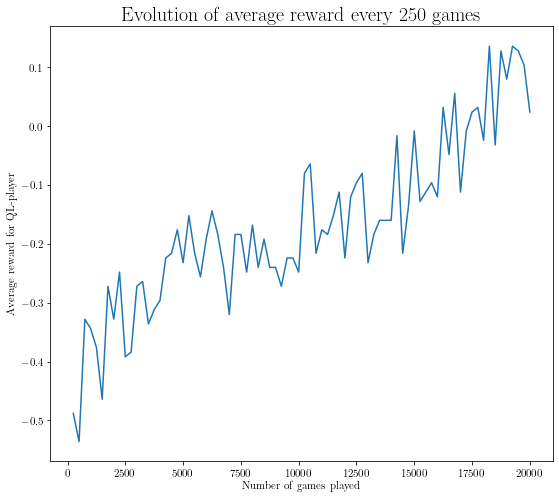

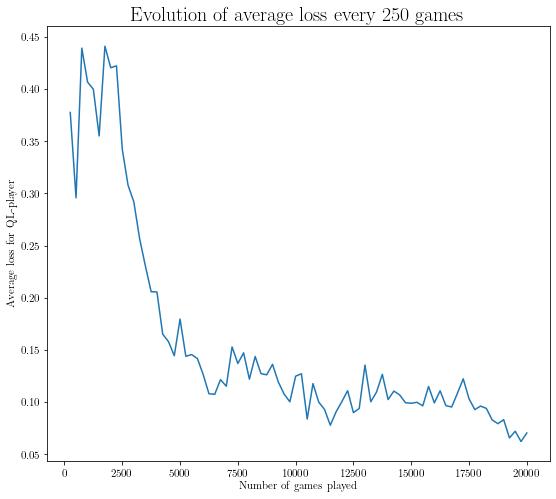

In [8]:
policy_net = helpers.DQN().to(device)
target_net = helpers.DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = Memory_Q12()
Q12(policy_net, target_net, memory, eps = 0.1, eps_opt = 0.5, nb_games=20000, question='q3-12')

Question 13

In [24]:
def DQN_Q14(N_star, policy_net, target_net, memory, nb_games = 20000, eps_min = 0.1, eps_max = 0.8, alpha = 0.1, gamma = 0.99, 
       step = 250, seed = None, question = 'q3-14', nb_samples = 5, save = True):
    """
    Implements the solution to the 14th question
    - inputs: 
        - N_star: a list containing the values of n*, dtype: list
        - nb_games: the number of games to play. Default: 20000, dtype: int
        - eps_min: the minimal value for the exploration level of the QL-player. Default: 0.1, dtype: float
        - eps_max: the maximal value for the exploration level of the QL-player. Default: 0.8, dtype: float
        - alpha: learning rate of the QL-player. Default: 0.1, dtype: float
        - gamma: discount factor of the QL-player. Default: 0.99, dtype: float
        - step: number of games to play before calculating the average reward. Default: 250, dtype: int
        - seed: the user can set a given seed for reproducibility. Default: None
        - question: string used to differentiate between the plots for each question. 
            Only used if 'save' is True. Default: 'q3-14', dtype: str
        - nb_samples: if this number is higher than 1, the 'nb_games' are played several times and then averaged in order to take into account the schocasticity of te problem. Default: 5, dtype: int
        - save: if set to False, the plots are only displayed but not saved. Default: True, dtype: bool
    - outputs: 
        - a figure with a plot for each n* representing the average reward every 'step' games for the QL-player. According to the value of the argument 'nb_samples', two different figures can be produced. Figures are saved in a folder Data if the argument 'save' is set to True.
        - returns the final rewards for each n* as a dictionnary
    """
    #wf.Q2_warning(N_star, nb_games, eps_min, eps_max, alpha, gamma, step, question, nb_samples, save)
    
    plt.figure(figsize = (9, 8))
    legend = []
    Final_rewards = {}
    for j, n_star in enumerate(N_star):
        Rewards = np.zeros(int(nb_games / step))
        Steps = np.zeros(int(nb_games / step))
        for s in range(nb_samples):
            env = NimEnv(seed = seed)
            eps = max(eps_min, eps_max * (1 - 1 / n_star))
            playerOpt = OptimalPlayer(epsilon = 0.5, player = 0)
            playerDQN = DQN_Player(player = 1, policy_net = policy_net, target_net= target_net, memory=memory, EPS_GREEDY = eps) 
            total_reward = 0.0
            for i in range(nb_games):
                # switch turns at every game
                if i % 2 == 0:
                    playerOpt.player = 0
                    playerDQN.player = 1
                else:
                    playerOpt.player = 1
                    playerDQN.player = 0
        
                new_reward, _ = DQN_one_game(playerDQN, playerOpt, env, update = True)
                total_reward += new_reward
                if i % step == step - 1:
                    Rewards[i // step] += total_reward / step
                    total_reward = 0.
                    Steps[i // step] = i
                env.reset(seed = seed)
                playerDQN.EPS_GREEDY = max(eps_min, eps_max * (1 - (i + 2) / n_star)) # change eps for the next game (current game is (i+1))
        Rewards = Rewards / nb_samples
        plt.plot(Steps, Rewards)
        Final_rewards['{}'.format(n_star)] = Rewards[-1]
        legend.append(r"$n_* = {}$".format(n_star))
    plt.legend(legend)
    plt.title('Evolution of average reward with decrease of exploration level')
    plt.xlabel('Number of games played')
    plt.ylabel('Average reward for QL-player')
    if save:
        if nb_samples > 1:
            plt.savefig('./Data/' + question + '_' + str(nb_samples) + '_samples.png')
        else:
            plt.savefig('./Data/' + question + '.png')
    return Final_rewards

FAIRE RUNNER EN BAS ET FAIRE Q.14

In [25]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
memory = ReplayMemory(buffer_size)
N_star = [2, 3]
DQN_Q14(N_star, policy_net, target_net, memory)